## Imports

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from PIL import Image
import cv2
from functools import reduce
from sklearn.model_selection import train_test_split

## Set variables

In [168]:
root_path = 'root/path/to/data/' # change this to the path where the data is stored
csv_path = f'{root_path}SUMediPose.csv'
rec_index = 20
cal_size = 60

## Load SUMediPose Dataset

In [169]:
df = pd.read_csv(csv_path)
print(f'Lenght of df: {len(df)}')
df.head()

Lenght of df: 2896943


id cam subject action speed  index  \
0  C1S2A1D1_0000  C1      S2     A1    D1      0   
1  C1S2A1D1_0002  C1      S2     A1    D1      2   
2  C1S2A1D1_0003  C1      S2     A1    D1      3   
3  C1S2A1D1_0004  C1      S2     A1    D1      4   
4  C1S2A1D1_0005  C1      S2     A1    D1      5   

                                      path                            bbx  \
0  frames/C1/S2/C1S2A1D1/C1S2A1D1_0278.jpg  [138.0, 454.0, 817.0, 1061.0]   
1  frames/C1/S2/C1S2A1D1/C1S2A1D1_0279.jpg  [138.0, 453.0, 792.0, 1062.0]   
2  frames/C1/S2/C1S2A1D1/C1S2A1D1_0280.jpg  [135.0, 454.0, 782.0, 1061.0]   
3  frames/C1/S2/C1S2A1D1/C1S2A1D1_0281.jpg  [137.0, 456.0, 767.0, 1060.0]   
4  frames/C1/S2/C1S2A1D1/C1S2A1D1_0282.jpg  [140.0, 452.0, 754.0, 1064.0]   

                     internal_path            wcs_path  
0  internal_data/C1/S2/S2A1D1.json  WCS/S2/S2A1D1.json  
1  internal_data/C1/S2/S2A1D1.json  WCS/S2/S2A1D1.json  
2  internal_data/C1/S2/S2A1D1.json  WCS/S2/S2A1D1.json  
3  internal_data/C1/S2/S2A1D1.json  WCS/S2/S2A1D1.json  
4  internal_data/C1/S2/S2A1D1.json  WCS/S2/S2A1D1.json

## Filter dataset for 3D reconstruction
If the goal is to perform 3D reconstruction the following should be noted:
- 3D reconstruction requires at least two views from one valid stereo calibration pair
- For two-view reconstruction: C1&C2 or C1&C3 or C6&C4 or C6&C5
- For three-view reconstruction: C1&C2&C3 or C6&C4&C5

In [170]:
# Step 1: Define camera combinations that need to have matching indices
camera_pairs = [('C1', 'C2'), ('C1', 'C3'), ('C6', 'C4'), ('C6', 'C5')]  # Example for pairs
# camera_pairs = [('C1', 'C2', 'C3'), ('C6', 'C4', 'C5')]  # Example for triplets
# camera_pairs = [('C1', 'C2', 'C3', 'C6', 'C4', 'C5')]  # Example for all


# Step 2: Filter data by subject, action, and speed
grouped = df.groupby(['subject', 'action', 'speed'])

# To store the ids that satisfy the conditions
keep_ids = set()

# Step 3: Iterate over groups and apply filtering for each camera combination
for name, group in grouped:
    for cameras in camera_pairs:
        # Get rows for each camera in the combination
        camera_dfs = [group[group['cam'] == cam][['id', 'index']] for cam in cameras]

        # Merge all the camera dataframes on 'index'
        if len(camera_dfs) > 1:
            try:
                # Use reduce to apply multiple merges in sequence
                merged_df = reduce(lambda left, right: pd.merge(left, right, on='index', suffixes=('', '_duplicate')), camera_dfs)
                
                # Add all matching row ids from each merged dataframe to the keep_ids set
                for col in merged_df.columns:
                    if col.startswith('id'):
                        keep_ids.update(merged_df[col])
            except:
                # In case any merge fails (no common 'index'), we skip
                continue

# Step 4: Filter the original dataframe to only include the rows with matching indices
df_3d = df[df['id'].isin(keep_ids)]

print(f"Number of matching rows: {len(df_3d)}")

Number of matching rows: 2389496


## Example of equally splitting the dataset

In [171]:
# Step 1: Create a column that combines 'cam', 'subject', 'action', and 'speed' using .loc
df.loc[:, 'stratify_col'] = df['cam'] + '_' + df['subject'] + '_' + df['action'] + '_' + df['speed'].astype(str)

# Step 3: Split the dataset into train and remaining (40% test/eval, 60% train)
train_df, remaining_df = train_test_split(df, test_size=0.4, stratify=df['stratify_col'], random_state=42)

# Step 4: Split the remaining data into eval and test (50% each of the remaining 40%)
eval_df, test_df = train_test_split(remaining_df, test_size=0.5, stratify=remaining_df['stratify_col'], random_state=42)

# Step 5: Remove the 'stratify_col' from all DataFrames
train_df = train_df.drop(columns=['stratify_col'])
eval_df = eval_df.drop(columns=['stratify_col'])
test_df = test_df.drop(columns=['stratify_col'])

# Step 6: Check the sizes of the splits
print(f"Train size: {len(train_df)}")
print(f"Eval size: {len(eval_df)}")
print(f"Test size: {len(test_df)}")



Train size: 1738165
Eval size: 579389
Test size: 579389


## Extracting specific data from the dataset

In [174]:
# Setup parameters
subject = 'S4'
action = 'A1'
speed = 'D1'

# Filter your dataframe
df_filtered = df[(df['subject'] == subject) & 
                 (df['action'] == action) & 
                 (df['speed'] == speed) &
                 (df['index'] == rec_index)]

# Extract image paths and bounding boxes
ids = df_filtered['id'].values.tolist()
image_paths = df_filtered['path'].values.tolist()
image_paths = [os.path.join(root_path, path) for path in image_paths]
bbxs = df_filtered['bbx'].values.tolist()
bbxs = [eval(bbx) for bbx in bbxs]  #bbx is stored as a string representation of a list
cams = df_filtered['cam'].values.tolist()
internal_paths = df_filtered['internal_path'].values.tolist()
internal_paths = [os.path.join(root_path, path) for path in internal_paths]
wcs_paths = df_filtered['wcs_path'].values.tolist()
wcs_paths = [os.path.join(root_path, path) for path in wcs_paths]

## Display bounding boxes

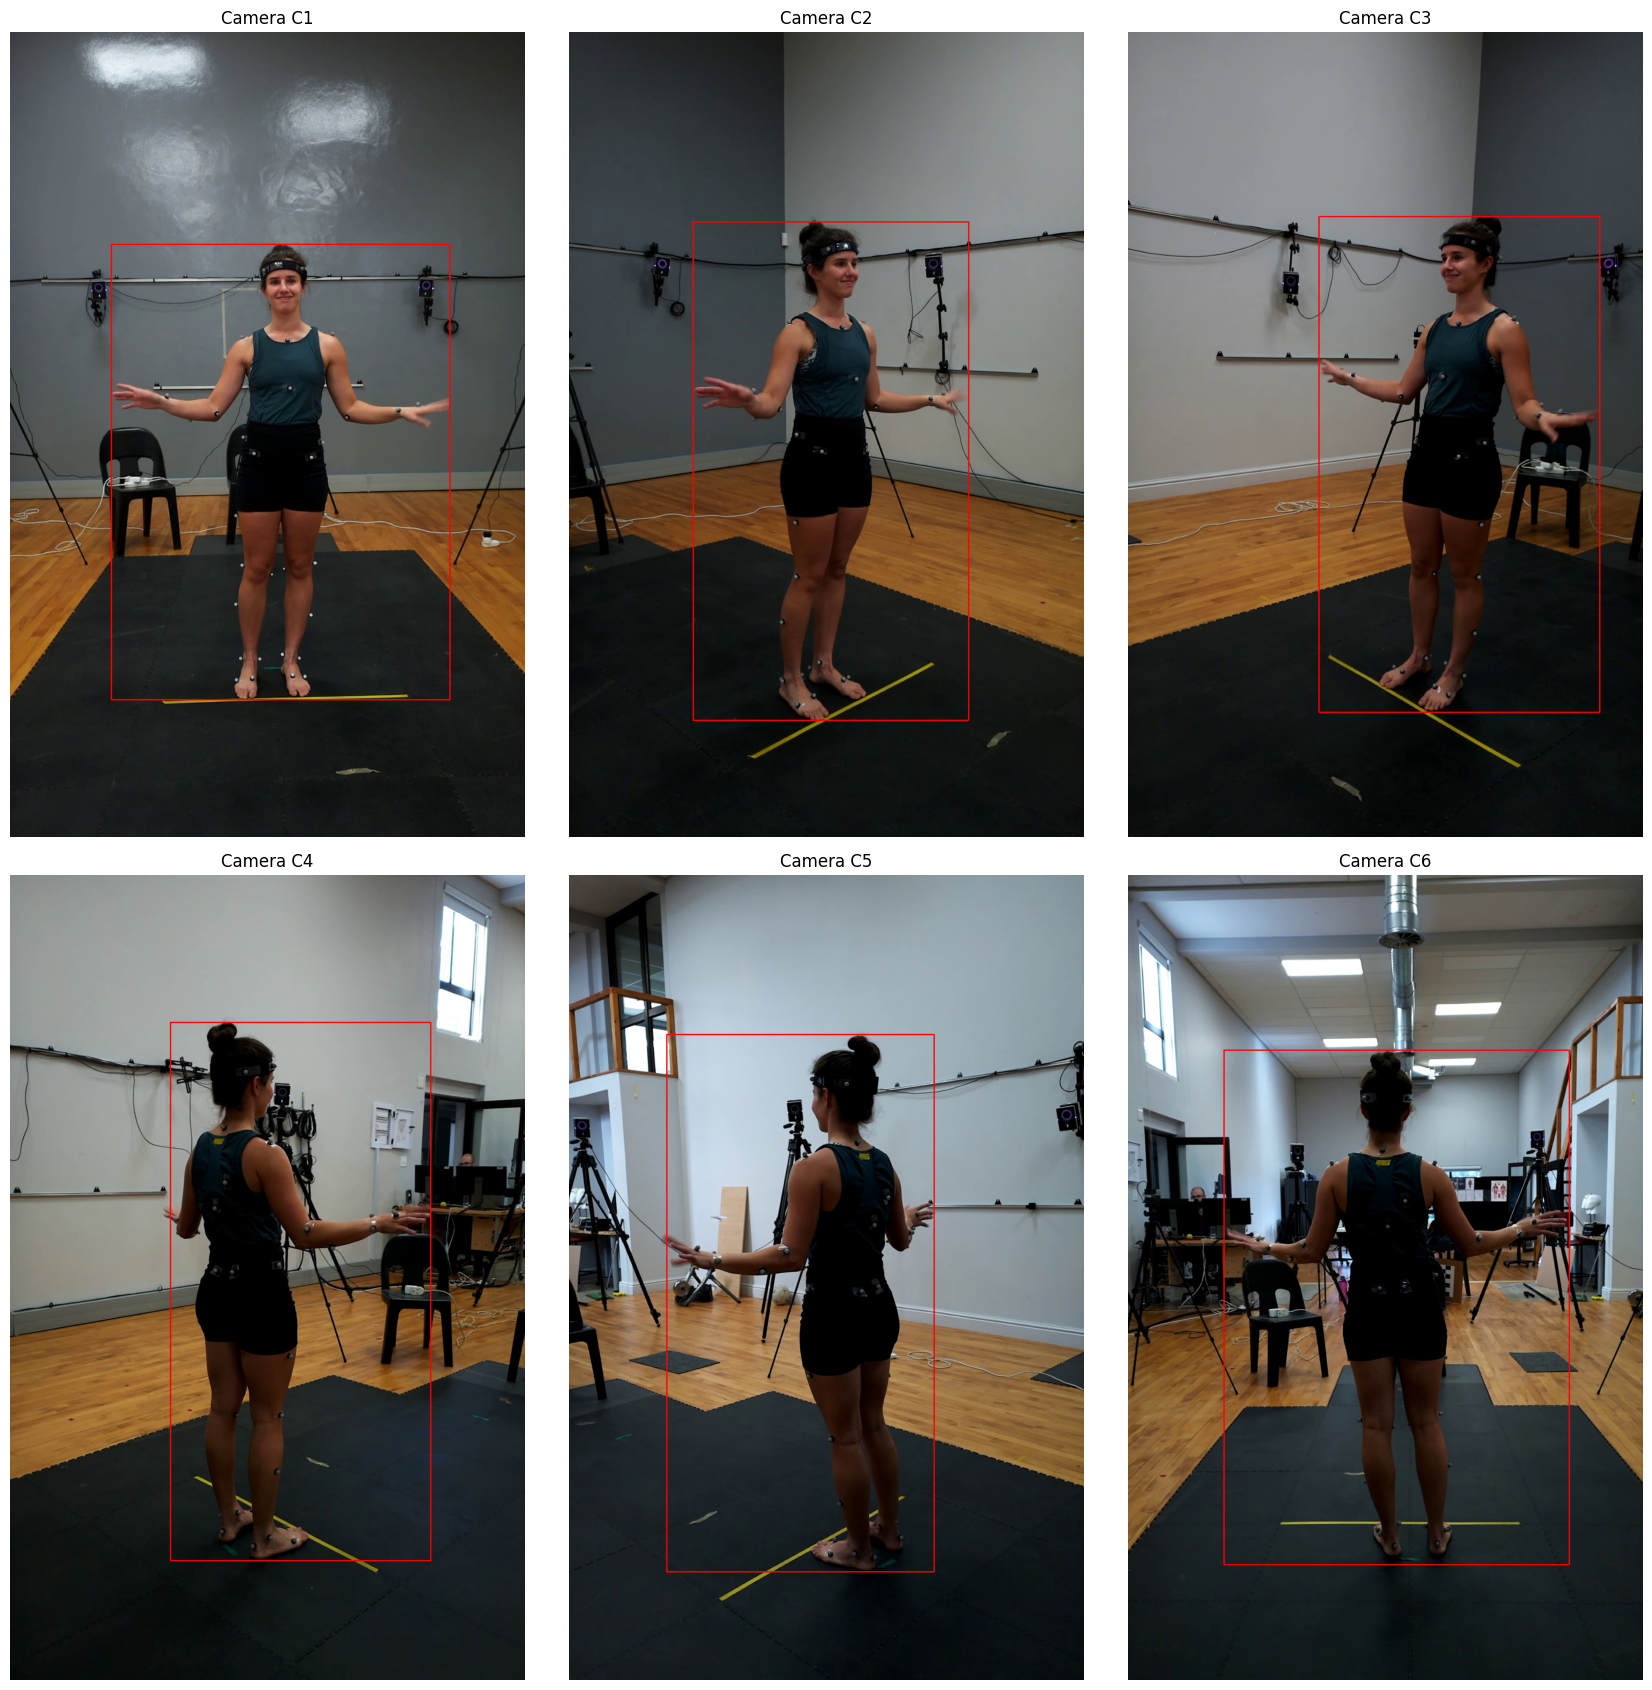

In [175]:
fig, axs = plt.subplots(2, 3, figsize=(17, 17))
axs = axs.ravel()

for i, ax in enumerate(axs):
    if i < len(image_paths):
        image = cv2.imread(image_paths[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Plot the bounding box (bbx format is [x, y, width, height])
        bbx = bbxs[i]
        start_point = (int(bbx[0]), int(bbx[1]))
        end_point = (int(bbx[0] + bbx[2]), int(bbx[1] + bbx[3]))
        image = cv2.rectangle(image, start_point, end_point, color=(255, 0, 0), thickness=2)
        ax.imshow(image)
        
        ax.set_title(f"Camera {cams[i]}")

        ax.axis('off')

plt.tight_layout()
plt.show()



## Displaying keypoints and IDs

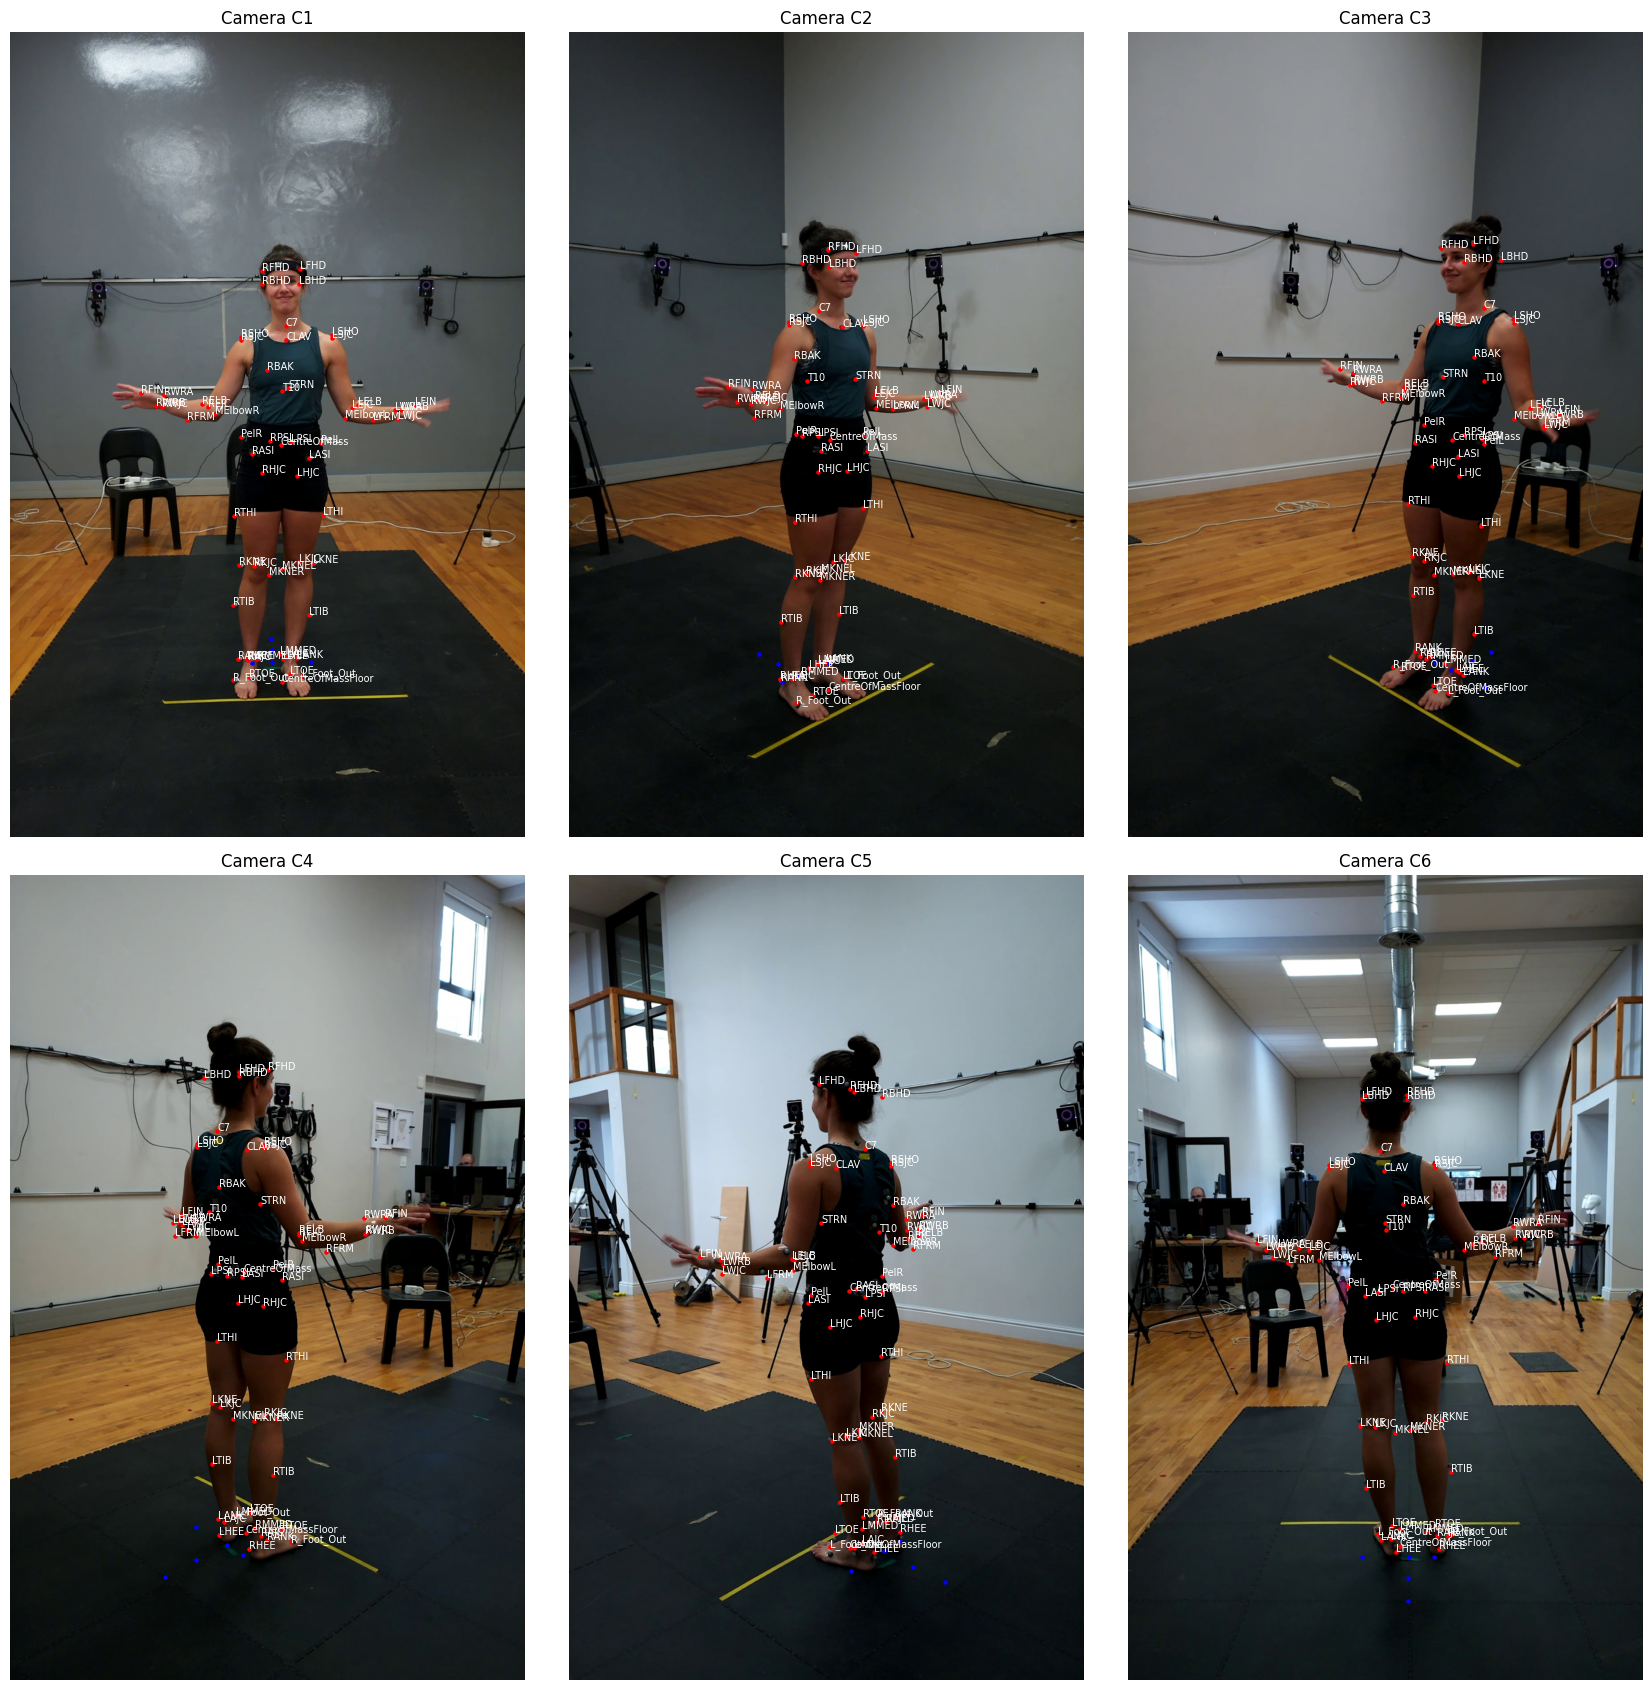

In [176]:
fig, axs = plt.subplots(2, 3, figsize=(17, 17))
axs = axs.ravel()

for i, ax in enumerate(axs):
    if i < len(image_paths):

        with open(internal_paths[i], 'r') as f:
            internal_data = json.load(f)
            frame = internal_data[rec_index]


        xy = np.array(frame['xy'])
        wand_xy = np.array(frame['wand_xy'])
        point_ids = frame['point_ids']

        image = Image.open(image_paths[i])
        ax.imshow(image)

        #plot xy
        ax.scatter(xy[:, 0], xy[:, 1], c='r', s=5)
        for j, (x, y) in enumerate(xy):
            if np.isfinite(x) and np.isfinite(y):
                ax.text(x, y, str(point_ids[j]), fontsize=7, color='white')

        #plot wand_xy
        ax.scatter(wand_xy[:, 0], wand_xy[:, 1], c='b', s=5)    

        ax.set_title(f"Camera {cams[i]}")

        ax.axis('off')

plt.tight_layout()
plt.show()


## Displaying 3D keypoint data in all 6 camera views

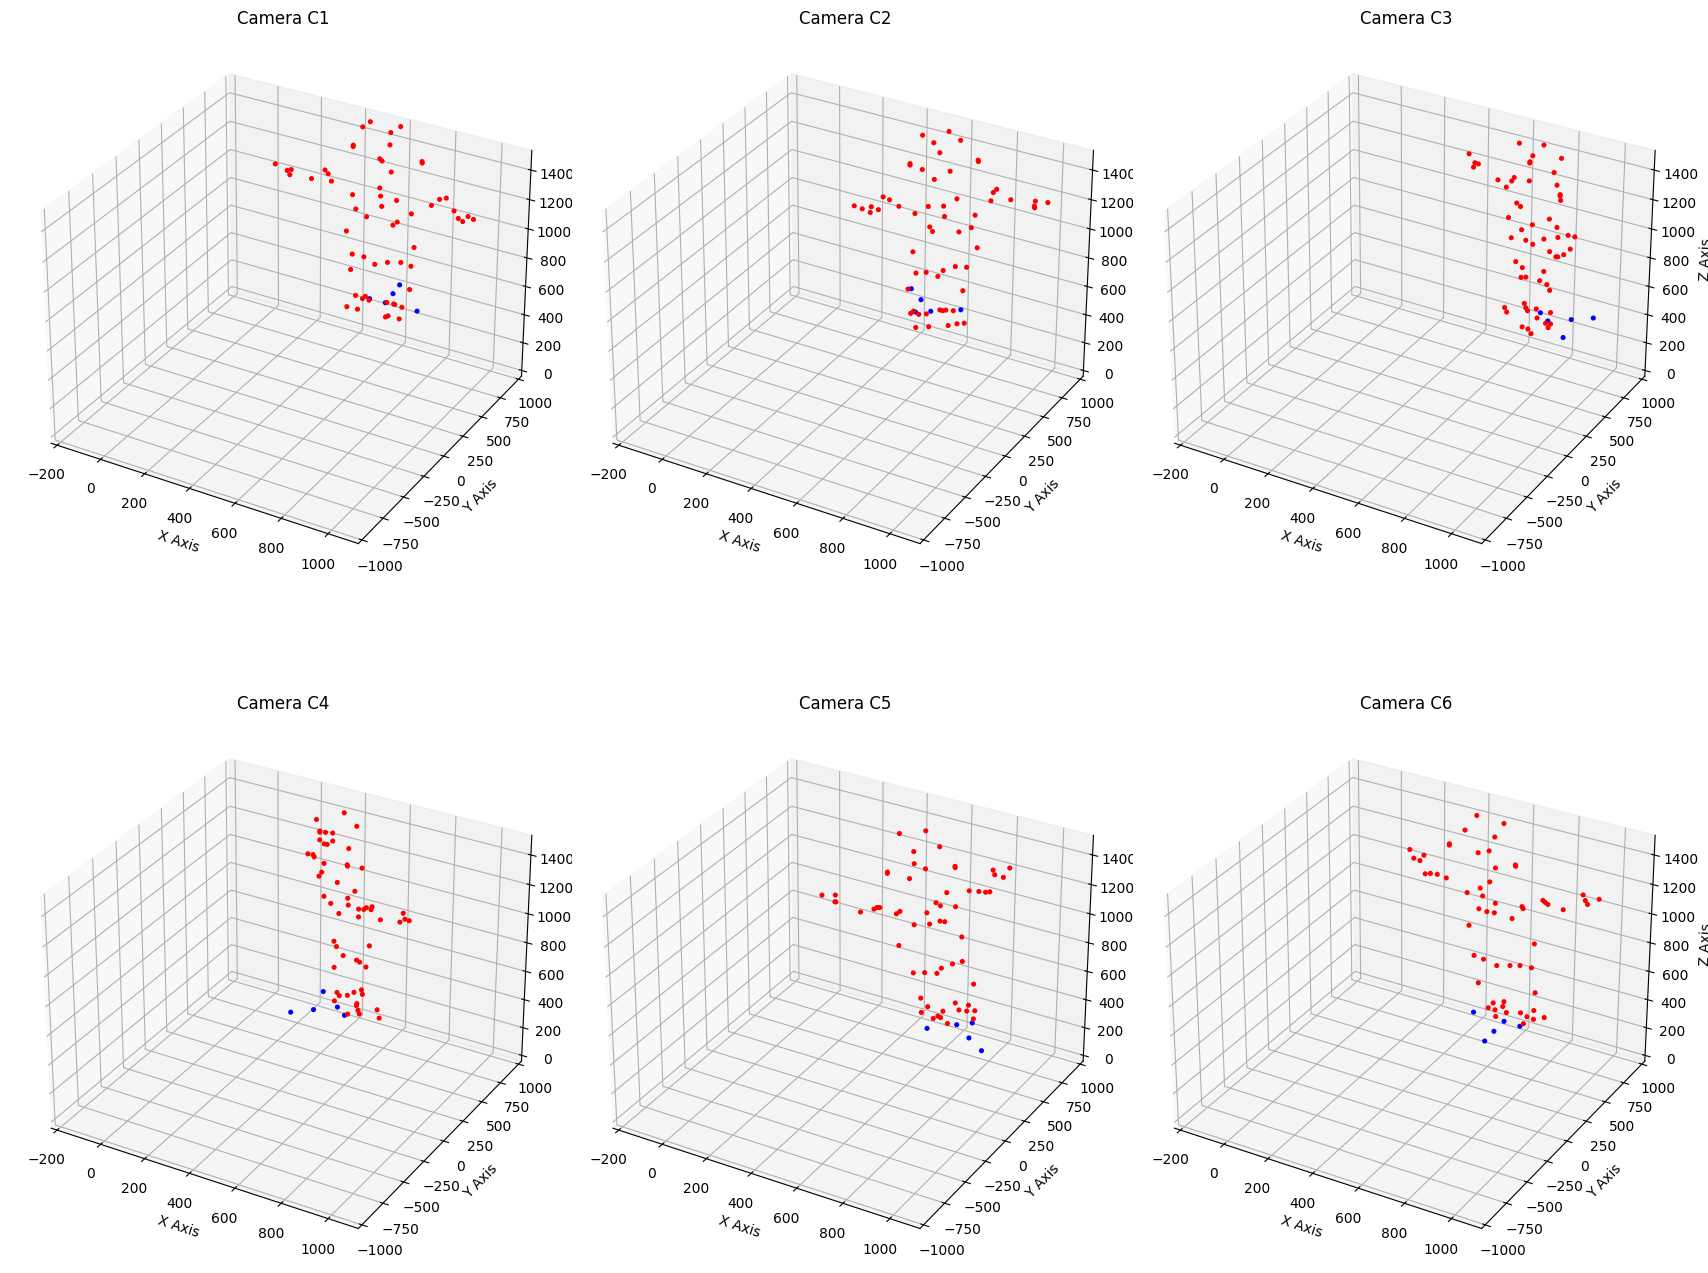

In [177]:
# Create a figure with 6 3D subplots arranged in a 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(17, 15), subplot_kw={'projection': '3d'})
axs = axs.ravel()

for i, ax in enumerate(axs):
    if i < len(wcs_paths):
        # Load WCS data
        with open(internal_paths[i], 'r') as f:
            internal_data = json.load(f)
            frame = internal_data[rec_index]

        # Extract xyz coordinates
        xyz = np.array(frame['xyz'])
        x = xyz[:, 0]*cal_size
        z = xyz[:, 1]*-cal_size
        y = xyz[:, 2]*cal_size

        # Plot predicted data points in 3D
        ax.scatter(x, y, z, c='r', marker='o', alpha=1, label='WCS keypoints', s=7)

        wand_xyz = np.array(frame['wand_xyz'])
        wand_x = wand_xyz[:, 0]*cal_size
        wand_z = wand_xyz[:, 1]*-cal_size
        wand_y = wand_xyz[:, 2]*cal_size

        # Plot predicted data points in 3D
        ax.scatter(wand_x, wand_y, wand_z, c='b', marker='o', alpha=1, label='WCS wand', s=7)

        # Set labels for axes
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')

        # Set axis ranges
        ax.set_xlim(-200, 1100)
        ax.set_ylim(-1000, 1000)
        ax.set_zlim(-10, 1500)

        # Set title
        ax.set_title(f"Camera {cams[i]}")

plt.tight_layout()
plt.show()


## Displaying 3D keypoint data within WCS (Vicon)
This data is the ame for all 6 camera views

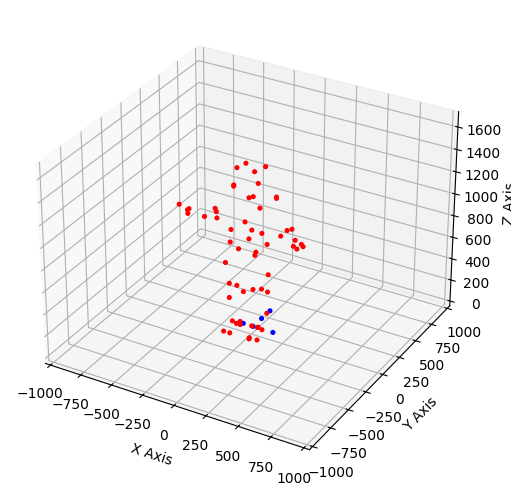

In [179]:
# Create a figure with a 3D subplot
fig = plt.figure(figsize=(5, 5))  # Create a figure with larger width
ax = fig.add_subplot(111, projection='3d')  # 3D subplot

with open(wcs_paths[0], 'r') as f:
    wcs_data = json.load(f)
    frame = wcs_data[rec_index]

wcs_xyz = np.array(frame['xyz'])

# Extract x, y, z coordinates for predicted data
x = wcs_xyz[:, 0]
z = wcs_xyz[:, 1]
y = wcs_xyz[:, 2]

# Plot predicted data points in 3D
ax.scatter(x, y, z, c='r', marker='o', alpha=1, label='WCS keypoints', s=7)

wand_xyz = np.array(frame['xyz_wand'])

# Extract x, y, z coordinates for predicted data
wand_x = wand_xyz[:, 0]
wand_z = wand_xyz[:, 1]
wand_y = wand_xyz[:, 2]

# Plot predicted data points in 3D
ax.scatter(wand_x, wand_y, wand_z, c='b', marker='o', alpha=1, label='WCS wand', s=7)

# Add labels for the axes
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# Set axis ranges
ax.set_xlim(-1000, 1000)
ax.set_ylim(-1000, 1000)
ax.set_zlim(-10, 1700)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()
